# **Image Compression : K-means Clustering**

<img src="https://raw.githubusercontent.com/ahsan-83/Machine-Learning-Projects/main/Image%20Compression/images/k_means_clustering.png" width="600">

---

# **Introduction**

K-means clustering algorithm is implemented to compress image in this project.

## Notebook Contents

- [Packages](#section1)
- [K-means Clustering Algorithm](#section2)
- [Image Compression with K-means](#section3)

<a name='section1'></a>
# **Packages**
 
- [numpy](www.numpy.org) is the fundamental package for scientific computing with Python.
- [matplotlib](http://matplotlib.org) is a library to plot graphs in Python.
- [PIL](https://pypi.org/project/Pillow/) is a Python imaging library for image processing


In [1]:
import numpy as np
import PIL
from PIL import Image

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

import sys
sys.path.append('/content/drive/MyDrive/Deep Learning/ImageCompress')
directory = '/content/drive/MyDrive/Deep Learning/ImageCompress/'

Mounted at /content/drive


<a name='section2'></a>
# **K-means Clustering Algorithm**

K-means is a clustering algorithm to automatically partition $N$ data points into $K$ clusters where each data point belongs to the cluster with the nearest mean (cluster centroid). Cluster centroids are choosen such as squared Euclidean distance with each data point is minimized. 

- K-means is an iterative procedure that initates with random centroids.
- In each step assign each data point to their closest centroids.
- Recompute the mean of each centroid using the points assigned to it

```python
% Initialize centroids
centroids = kMeansInitCentroids(X, K) 

for iter = 1:iterations
    % Assign each data point to the closest centroid 
    idx = findClosestCentroids(X, centroids)
    
    % Compute means based on centroid assignments
    centroids = computeMeans(X, idx, K);
end
```

<img src="https://raw.githubusercontent.com/ahsan-83/Machine-Learning-Projects/main/Image%20Compression/images/k_means.gif" width="600">

## Random Centroid Initialization

K-means clustering centroids are initialized by selecting random points from data set as implemented in `kMeansInitCentroids`.

Randomly permutes data points and select first K from random permutation set

```python
% Randomly reorder the indices of data points
randidx = randperm(size(X, 1))

% Select first K data points as centroids
centroids = X(randidx(1:K), :)
```

In [3]:
def kMeansInitCentroids(data,K):
    
    # create centroid of shape (K, data point shape)
    centroids = np.zeros((K,data.shape[1]))

    # generate random permutation of data points
    random_data = np.random.permutation(data)

    # select first K data points from random permutation
    centroids = random_data[0:K,:]

    return centroids

## Finding Closest Centroids

In K-means clustering, each data point $x^{(i)}$ is assigned to its closest centroid as implemented in `findClosestCentroids`

$$ c^{(i)} = j\: that\: minimizes\: ||x^{(i)} − \mu_{j}||^2$$

- $c^{(i)}$ : Index of the centroid closest to $x^{(i)}$
- $\mu_{j}$ : Value of $j$th centroid.
- $||x^{(i)} − \mu_{j}||^2$ : Squared Euclidean distance between  $x^{(i)}$ and  $\mu_{j}$


In [4]:
def findClosestCentroids(data,K,centroids):
    
    data_len = data.shape[0]

    # closest centroid index for each data point 
    data_centroids = np.zeros((data_len,1))

    dist = np.zeros((K,1))
    
    errors = []

    # loop over each data point
    for i in range(data_len):

        # compute squared Euclidean distance between each data point and centroids
        dist = np.linalg.norm(data[i] - centroids,axis=-1)

        # compute centroid index that minimizes squared Euclidean distance for data point
        data_centroids[i] = np.argmin(dist)

        # compute minimum distance as error
        error = np.amin(dist)
        errors.append(error)

    return data_centroids, errors

## Compute Centroid Means

K-means clustering each centroid is recomputed by taking mean of the data points assigned to it, as implemented in `computeMeanCentroids`

$$\mu_{k} = \frac{1}{|C_{k}|} \sum_{i \epsilon C_{k}} x^{(i)}$$

- $C_{k}$ : Data points assigned to centroid k
- $\mu_{k}$ : Mean of data points assigned to centroid k


In [5]:
def computeMeanCentroids(data,data_centroids,centroid_shape,K):
    
    centroids = np.zeros(centroid_shape)

    # recompute each centroid
    for i in range(K):

        # data points assigned to ith centroid
        data_mask = data_centroids == i
        
        # total data points assigned to ith centroid
        total_mask = data_mask.sum()

        # compute mean of data points assigned to ith centroid
        centroids[i] = np.sum(data * data_mask, axis=0)/total_mask
    
    return centroids

## K-means Clustering 

K-means clustering algorithm is implemented in `kMeanClustering` using above functions.

Default clustering iteration : 10

In [6]:
def kMeanClustering(data, K=16, max_iter=10, log_cluster_iter=False):
    
    # initialize clustering centroids
    centroids = kMeansInitCentroids(data,K)

    # closest centroid index for data points
    data_centroids = np.zeros(data.shape)

    # clustering errors
    errors = []
    
    if log_cluster_iter:
      print('Clustering Start')
        
    # clustering iteration
    for i in range(max_iter):
      
      # find closest centroid index for data points
      data_centroids, error = findClosestCentroids(data,K,centroids)
      
      # store clustering error in each iteration
      errors.append(error)

      # recompute centroids based on centroid assignments
      centroids = computeMeanCentroids(data,data_centroids,centroids.shape,K)

    if log_cluster_iter:
        print('Clustering End')
    
    return centroids, data_centroids, errors

<a name='section3'></a>
# **Image Compression with K-means**

In a 24-bit color representation of an image, each pixel is represented as three 8-bit unsigned integers (ranging from 0 to 255) specifically Red, Green and Blue intensity values which is known as RGB encoding. Every image contains thousands of colors and we can compress an Image by reducing the numbers of colors to 16 colors. Thus we will only store the RGB values of the 16 colors, and for each pixel we only need to store the index (4 bit to represent 16 color ) of assigned color.

K-means clustering algorithm is used to partition image pixel color values in to 16 clusters (color values) which will be used to represent the compressed image. So we run K-means clustering on image color values with K = 16.

## Process Image

- Image data is normalized into range [0,1] after laoding
- Image data is reshaped from (width, height, 3) to (width * height, 3)

In [7]:
def process_image(image):

    # convert image into array 
    image_data = np.array(image, dtype='float32')
    image_original_data = image_data    

    print('Image Shape : ',image_data.shape)

    # normalize image data into range [0,1]
    image_data /= 255

    # reshape image data (width, height, RGB channel) into (width * height, RGB channel) shape 
    image_data = image_data.reshape(image_data.shape[0]*image_data.shape[1],image_data.shape[2])

    return image_original_data, image_data

In [8]:
image = Image.open(directory+'parrotx.jpg')
image_original_data, image_data = process_image(image)

Image Shape :  (210, 127, 3)


## Run K-means Clustering

K-means algorithm may not always converge to ideal centroids and depends on the initialization of centroids. 

So, K-means algorithm is usually run multiple times with different random initializations and centroids which has lowest error are choosen. 

After processing image data, K-means clustering is run 20 times using `kMeanClustering` with parameter K = 16 and clustering iteration = 10.

In [9]:
# store centroids, errors and data centroids for clustering iterations
centroids_list = []
error_list = []
min_error_list = []
data_centroids_list = []

# run K-means 20 times
for i in range(20):
    
    centroids, data_centroids, error = kMeanClustering(image_data,16)

    # store centroids, data centroids and errors
    centroids_list.append(centroids)
    data_centroids_list.append(data_centroids)
    error_list.append(error)
    min_error_list.append(np.amin(error))
    print('#',end=' ')

print('Clustering complete')

# # # # # # # # # # # # # # # # # # # # Clustering complete


## Clustering Error Analysis

Optimum error and errors generated from running K-means clustering (K=16) 20 times is shown below

In [ ]:
optimum_error_idx = np.argmin(min_error_list)
optimum_error = np.amin(min_error_list)
error_iter = np.arange(0,10,1)

for i in range(20):
    if i == optimum_error_idx:
        continue;
    plt.plot(error_iter,error_list[i],marker='o',markersize=2)

plt.plot(error_iter,error_list[optimum_error_idx],marker='X',c='blue',markersize=4,label='Optimum Error')    
plt.xlabel('Clustering iteration')
plt.ylabel('Clustering Error')
plt.legend()
plt.show()

print('Optimum Clustering Error : ',optimum_error)

/usr/local/lib/python3.9/dist-packages/IPython/core/pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


## Generage Compressed Image

After running K-means clustering for 20 times, centroids for image compression are choosen which has lowest error.

Compressed image is generated by assigning each pixel color from centroid colors to which the pixel color value is closest.

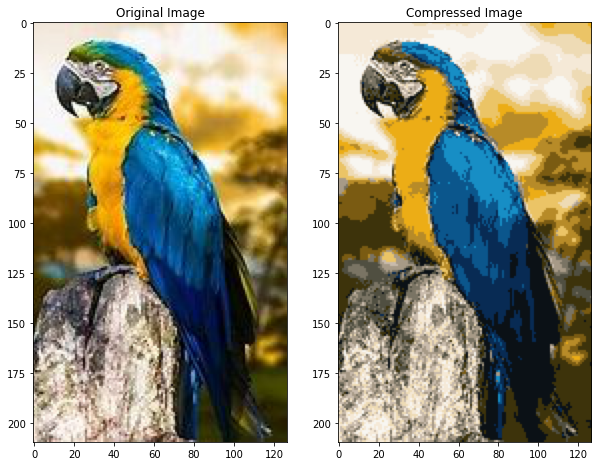

In [13]:
optimum_error_idx = np.argmin(min_error_list)
optimum_error = np.amin(min_error_list)

centroids = centroids_list[optimum_error_idx]
data_centroids = data_centroids_list[optimum_error_idx]

compressed_image_data = np.zeros(image_data.shape)

for i in range (image_data.shape[0]):
    compressed_image_data[i] = centroids[data_centroids[i].astype(int)] * 255

compressed_image_data_reshaped = compressed_image_data.reshape(image_original_data.shape)
compressed_image = Image.fromarray(compressed_image_data_reshaped.astype(np.uint8),'RGB')


fig, axs = plt.subplots(1,2,figsize=(10, 12))
axs[0].imshow(image)
axs[0].set_title('Original Image')
axs[1].imshow(compressed_image)
axs[1].set_title('Compressed Image')
plt.show()

## Clustering Visualization

RGB color values and centroids after K-means clustering is shown in scatter plot

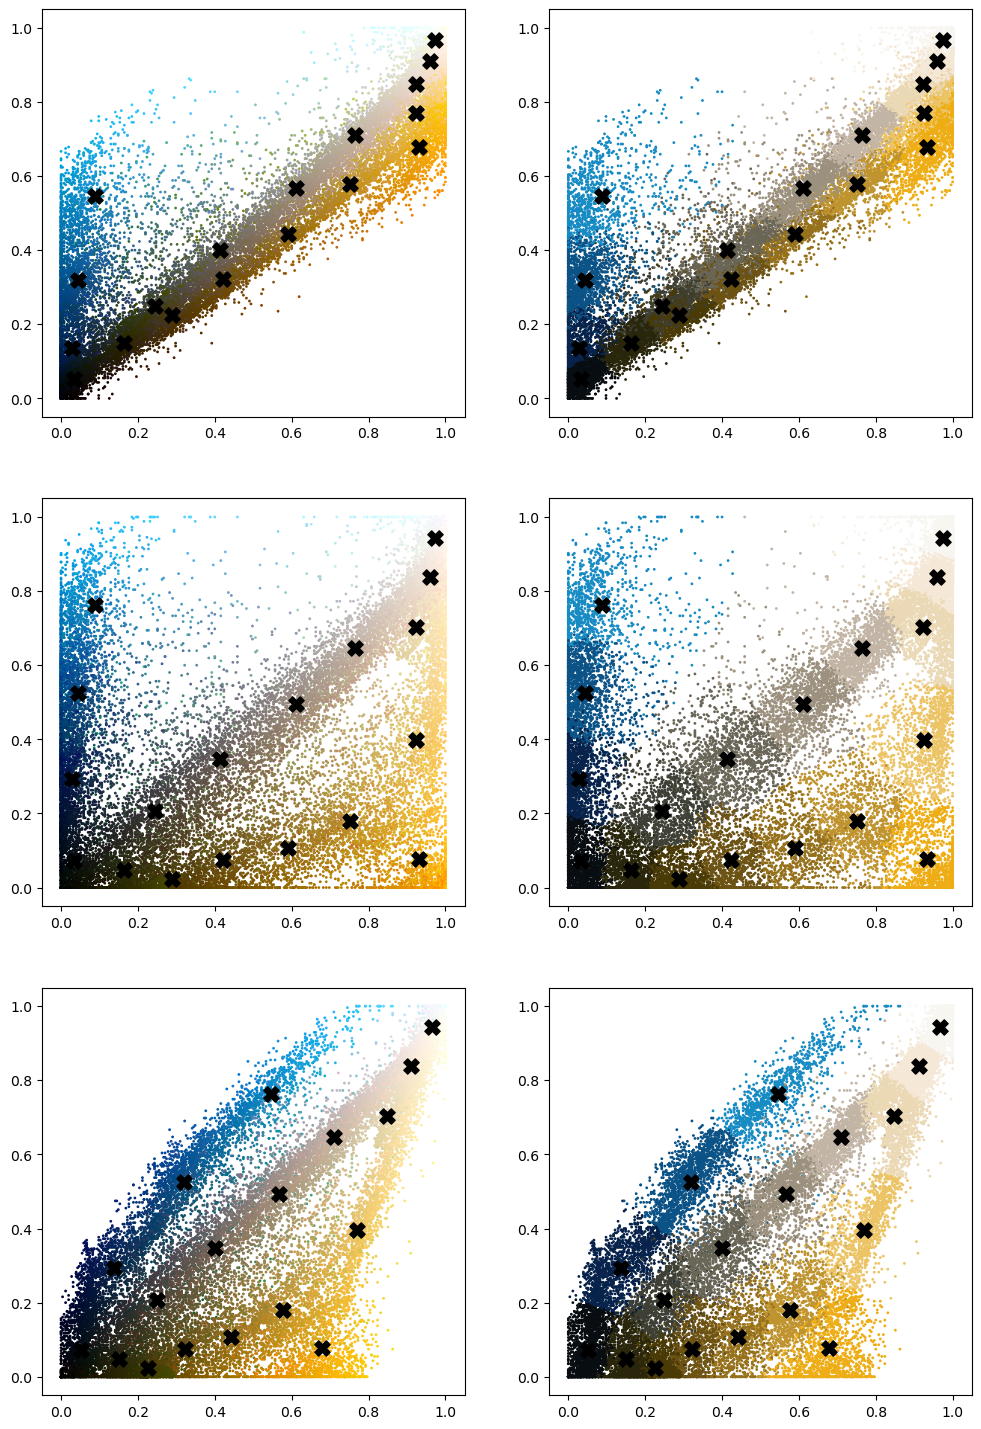

In [ ]:
from matplotlib.colors import rgb2hex

t_image_data = np.transpose(image_data)
compressed_image_data = compressed_image_data / 255
compressed_image_data = compressed_image_data.reshape(image_data.shape)
t_centroids = np.transpose(centroids)

colors = []
compress_colors = []

for i in range(image_data.shape[0]):
    colors.append(rgb2hex(image_data[i]))

for i in range(image_data.shape[0]):
    compress_colors.append(rgb2hex(compressed_image_data[i]))
    
fig, axs = plt.subplots(3,2, figsize=(12, 18))

axs[0][0].scatter(t_image_data[0],t_image_data[1],s=1,c=colors);
axs[0][0].scatter(t_centroids[0],t_centroids[1],s=100,marker='X',c='black');
axs[0][0].set_xlabel('Red')
axs[0][0].set_ylabel('Blue')
axs[0][0].set_title('Original Image Colors')

axs[0][1].scatter(t_image_data[0],t_image_data[1],s=1,c=compress_colors);
axs[0][1].scatter(t_centroids[0],t_centroids[1],s=100,marker='X',c='black');
axs[0][1].set_xlabel('Red')
axs[0][1].set_ylabel('Blue')
axs[0][1].set_title('Clustered Image Colors')

axs[1][0].scatter(t_image_data[0],t_image_data[2],s=1,c=colors);
axs[1][0].scatter(t_centroids[0],t_centroids[2],s=100,marker='X',c='black');
axs[1][0].set_xlabel('Red')
axs[1][0].set_ylabel('Green')
axs[1][0].set_title('Clustered Image Colors')

axs[1][1].scatter(t_image_data[0],t_image_data[2],s=1,c=compress_colors);
axs[1][1].scatter(t_centroids[0],t_centroids[2],s=100,marker='X',c='black');
axs[1][1].set_xlabel('Red')
axs[1][1].set_ylabel('Green')
axs[1][1].set_title('Clustered Image Colors')

axs[2][0].scatter(t_image_data[1],t_image_data[2],s=1,c=colors);
axs[2][0].scatter(t_centroids[1],t_centroids[2],s=100,marker='X',c='black');
axs[2][0].set_xlabel('Blue')
axs[2][0].set_ylabel('Green')
axs[2][0].set_title('Clustered Image Colors')

axs[2][1].scatter(t_image_data[1],t_image_data[2],s=1,c=compress_colors);
axs[2][1].scatter(t_centroids[1],t_centroids[2],s=100,marker='X',c='black');
axs[2][1].set_xlabel('Blue')
axs[2][1].set_ylabel('Green')
axs[2][1].set_title('Clustered Image Colors')

fig.title('Clustering Visualization')
plt.show()